In [1]:
import scipy.io as sio
import pandas as pd

# 예: AD 그룹
mat = sio.loadmat('AD.mat')
print("MAT keys:", mat.keys())  
# → eeg signal 배열이 들어있는 키(예: 'EEG' 또는 'data')를 찾음

# 텍스트 파일 확인
# (탭 구분인지, 공백 구분인지, 헤더 유무에 따라 sep와 header를 조정)
txt = pd.read_csv('AD.txt', sep='\t', header=None)  
print(txt.shape, txt.head())

# MMSE 데이터 (소형 파일)
mmse = pd.read_csv('MMSE_data.txt', sep='\t')
print(mmse.head())


MAT keys: dict_keys(['__header__', '__version__', '__globals__', 'AD'])
(32617, 1)                                                    0
0                                             Epoch:
1  69.811737 69.892502 -34.192719 0.491496 -9.888...
2  41.472076 67.945442 -35.813026 -5.006111 -7.45...
3  4.857930 61.946964 -28.839586 -18.863247 -6.76...
4  -24.515345 54.691158 -18.951553 -41.578449 -3....
  Mental State    Age  O place  O time  Reg     Att  Name  Rep  Read  Write  \
0          NaN    NaN      NaN     NaN  NaN  & Calc   NaN  NaN   NaN    NaN   
1       Normal  75-80      5.0     5.0  3.0       4   2.0  2.0   1.0    1.0   
2       Normal  70-75      5.0     5.0  3.0       5   3.0  2.0   1.0    1.0   
3       Normal  65-70      5.0     5.0  3.0       4   2.0  2.0   0.0    1.0   
4       Normal  60-65      5.0     5.0  3.0       5   3.0  2.0   1.0    1.0   

    DR   VS  Comm  Total MMSE gender  Unnamed: 15  
0  NaN  NaN   NaN         NaN    NaN          NaN  
1  0.0  1.0   3.0   

In [6]:
import numpy as np
import scipy.io as sio

# 1) MAT 파일 불러오기 (struct_as_record=False, squeeze_me=True)
mat = sio.loadmat('AD.mat', struct_as_record=False, squeeze_me=True)

# 2) 키 확인
print("MAT keys:", mat.keys())

# 3) AD 변수 꺼내기
AD = mat['AD']
print("AD object type:", type(AD))
# 배열인지 확인
if isinstance(AD, np.ndarray):
    print(" AD.shape:", AD.shape)
    print(" AD.dtype:", AD.dtype)

# 4) 실제 record가 들어있는 요소 꺼내기
if isinstance(AD, np.ndarray):
    # 스칼라 배열(0-d) 혹은 (1,) 배열이라면 .item() 사용
    if AD.shape == () or AD.shape == (1,):
        rec = AD.item()
    else:
        # 다차원에 여러 레코드가 있으면 첫 번째만 확인
        rec = AD.flat[0]
else:
    rec = AD

# 5) record 타입, 필드명 확인
print("Record type:", type(rec))
# struct-like 객체라면 .__dict__ 혹은 _fieldnames 사용
if hasattr(rec, '_fieldnames'):
    print("Fields:", rec._fieldnames)
elif hasattr(rec, 'dtype') and rec.dtype.names:
    print("Structured array fields:", rec.dtype.names)
else:
    print("No struct fields found; rec attributes:", dir(rec)[:20])


MAT keys: dict_keys(['__header__', '__version__', '__globals__', 'AD'])
AD object type: <class 'numpy.ndarray'>
 AD.shape: (13,)
 AD.dtype: object
Record type: <class 'scipy.io.matlab._mio5_params.mat_struct'>
Fields: ['epoch', 'odor', 'noisy']


In [9]:
# rec는 이전에 load_mat_struct 로 불러온 mat_struct 객체입니다.
first_epoch = rec.epoch[0]

# 1) shape 확인
n_times, n_ch = first_epoch.shape
print(f"  → {n_ch} channels, {n_times} timepoints per epoch")

# 2) Generic 채널명 생성
ch_names = [f"EEG{i+1}" for i in range(n_ch)]
print("  → channel names:", ch_names[:10], "...")  # 앞 10개만 예시

# 3) 샘플링 레이트 추정
#    반드시 실험 프로토콜에서 "한 epoch의 길이(초)"를 확인해 넣으세요!
epoch_duration_s = 2.0   # ← 예: 2초(논문·매뉴얼에서 확인한 값으로 교체)
sfreq = n_times / epoch_duration_s
print(f"  → inferred sampling rate: {sfreq:.1f} Hz")


  → 59 channels, 600 timepoints per epoch
  → channel names: ['EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'EEG7', 'EEG8', 'EEG9', 'EEG10'] ...
  → inferred sampling rate: 300.0 Hz


In [13]:
# 1) rec 로드 (이전 load_mat_struct 사용)
rec = load_mat_struct('AD.mat', 'AD')

# 2) rec.epoch shape 확인
n_ch, n_times, n_trials = rec.epoch.shape
print(f"{n_ch} channels, {n_times} samples per epoch, {n_trials} trials")

# 3) 문헌 기반 채널 이름
ch_names = ['Fp1', 'Fz', 'Cz', 'Pz']
assert len(ch_names) == n_ch

# 4) 문헌 기반 epoch 길이 (s)
epoch_duration_s = 1.0 + 2.0  # 1s pre + 2s post = 3 s

# 5) 샘플링 레이트 계산
sfreq = n_times / epoch_duration_s
print(f"Inferred sampling rate: {sfreq:.1f} Hz")  # → 600 samples / 3 s = 200 Hz

# 6) MNE 호환 형태로 axes 재배열: (n_trials, n_ch, n_times)
import numpy as np
X = np.transpose(rec.epoch, (2, 0, 1))  

# 7) MNE Info 생성 예시
import mne
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
print(info)


4 channels, 600 samples per epoch, 59 trials
Inferred sampling rate: 200.0 Hz
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fz, Cz, Pz
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 200.0 Hz
>


In [15]:
# rec 은 이전에 load_mat_struct 로 불러온 mat_struct 객체입니다.
epochs_list = list(rec.epoch)       # rec.epoch 요소를 리스트로
n_trials = len(epochs_list)

# 1) rec.odor / rec.noisy 의 타입과 shape 확인
import numpy as np
odor_arr  = np.array(rec.odor)
noisy_arr = np.array(rec.noisy)

print("n_trials:", n_trials)
print("odor_arr.shape:", odor_arr.shape, "noisy_arr.shape:", noisy_arr.shape)

# 2) 1차원으로 flatten 시도
odor_flat  = odor_arr.flatten()
noisy_flat = noisy_arr.flatten()

print("odor_flat length:", len(odor_flat),
      "noisy_flat length:", len(noisy_flat))

# 3) metadata dict 에 trial-wise로 들어갈 것들만 담기
meta_dict = {}
if len(odor_flat) == n_trials:
    meta_dict['odor'] = odor_flat
else:
    print("▶️ odor 길이가 에포크 수와 다릅니다. 생략합니다.")

if len(noisy_flat) == n_trials:
    meta_dict['noisy'] = noisy_flat.astype(bool)
else:
    print("▶️ noisy 길이가 에포크 수와 다릅니다. 생략합니다.")

# 4) DataFrame 생성
if meta_dict:
    meta = pd.DataFrame(meta_dict)
    print(meta.head())
else:
    meta = None
    print("메타데이터가 비어있습니다. DataFrame 을 만들지 않습니다.")


n_trials: 4
odor_arr.shape: (59,) noisy_arr.shape: (10,)
odor_flat length: 59 noisy_flat length: 10
▶️ odor 길이가 에포크 수와 다릅니다. 생략합니다.
▶️ noisy 길이가 에포크 수와 다릅니다. 생략합니다.
메타데이터가 비어있습니다. DataFrame 을 만들지 않습니다.


In [26]:
import numpy as np
import scipy.io as sio
import mne
from mne.preprocessing import ICA
from mne.filter import notch_filter
import warnings

# 로그·경고 억제
mne.set_log_level('WARNING')
warnings.filterwarnings('ignore', category=RuntimeWarning)

def load_mat_struct_auto(path):
    mat = sio.loadmat(path, struct_as_record=False, squeeze_me=True)
    keys = [k for k in mat if not k.startswith("__")]
    if len(keys) != 1:
        raise ValueError(f"{path}: data vars = {keys}")
    data = mat[keys[0]]
    if isinstance(data, np.ndarray):
        for el in data.flat:
            if hasattr(el, "_fieldnames"):
                return el
    return data

def preprocess_auto_thresh(rec, prefix, epoch_duration_s=3.0, pct=97):
    # 1) rec.epoch → (n_ch, n_times, n_epochs)
    arr = rec.epoch
    n_ch, n_times, n_epochs = arr.shape
    X = arr.transpose(2,0,1)  # → (epochs, ch, times)

    # 2) Info, epochs 만들기
    ch_names = ['Fp1','Fz','Cz','Pz'] if n_ch==4 else [f"EEG{i+1}" for i in range(n_ch)]
    sfreq = n_times/epoch_duration_s
    info  = mne.create_info(ch_names, sfreq, ch_types='eeg')
    epochs = mne.EpochsArray(X, info, tmin=-1.0, verbose=False)

    # 3) 필터링
    epochs.filter(1., 40., method='iir',
                  iir_params=dict(ftype='butter', order=4),
                  verbose=False)
    data = epochs.get_data()
    for e in range(n_epochs):
        data[e] = notch_filter(data[e], Fs=sfreq, freqs=[50.0])
    epochs._data = data

    # 4) ICA
    ica = ICA(n_components=min(n_ch,15), random_state=42, max_iter='auto', verbose=False)
    ica.fit(epochs)
    epochs = ica.apply(epochs, verbose=False)

    # 5) 자동 임계값 계산 (peak-to-peak 진폭의 p번째 퍼센타일)
    ptp = epochs.get_data().ptp(axis=2)          # (n_epochs, n_ch)
    max_ptp = ptp.max(axis=1)                   # 에포크별 최대 ptp
    thresh = np.percentile(max_ptp, pct)        # 예: 97th percentile
    thresh_uv = thresh * 1e6                    # µV 단위로 보기
    epochs_before = epochs.copy()
    epochs.drop_bad(reject=dict(eeg=thresh), verbose=False)
    if len(epochs) == 0:
        epochs = epochs_before
        print(f"{prefix}: auto-thresh={thresh_uv:.0f} µV → all dropped, skip drop_bad")
    else:
        dropped = n_epochs - len(epochs)
        print(f"{prefix}: auto-thresh={thresh_uv:.0f} µV → dropped {dropped} epochs")

    # 6) Z-score
    d = epochs.get_data()
    epochs._data = (d - d.mean(axis=2, keepdims=True)) / d.std(axis=2, keepdims=True)

    # 7) 저장
    out = f"{prefix}_auto_preproc-epo.fif"
    epochs.save(out, overwrite=True, verbose=False)
    print(f"{prefix}: {len(epochs)} epochs remain → saved {out}\n")
    return epochs

# — 실행 예 —
for fname in ['AD.mat','MCI.mat','Normal.mat']:
    rec    = load_mat_struct_auto(fname)
    prefix = fname.replace('.mat','')
    preprocess_auto_thresh(rec, prefix)


AD: auto-thresh=8716896277 µV → dropped 2 epochs
AD: 57 epochs remain → saved AD_auto_preproc-epo.fif

MCI: auto-thresh=80246189 µV → dropped 4 epochs
MCI: 116 epochs remain → saved MCI_auto_preproc-epo.fif

Normal: auto-thresh=10461044312 µV → dropped 4 epochs
Normal: 115 epochs remain → saved Normal_auto_preproc-epo.fif



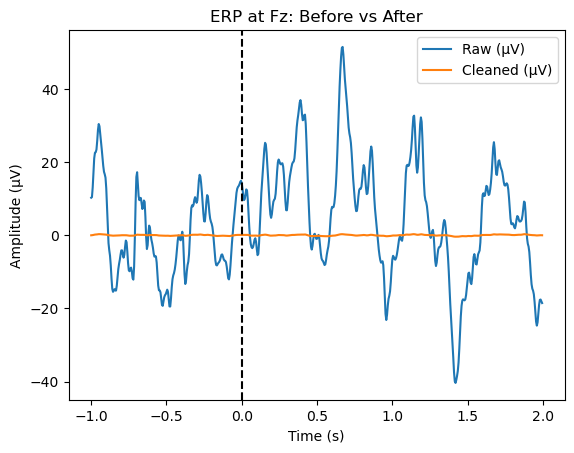

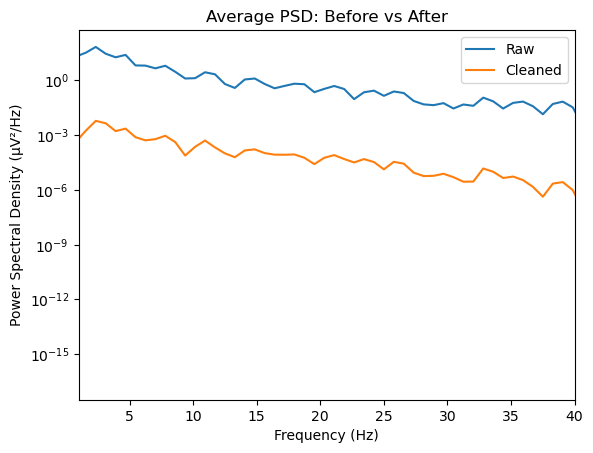

In [33]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import mne

# --- 1) raw_epochs와 clean_epochs가 이미 준비돼 있다고 가정 ---
# raw_epochs: 필터/ICA/drop_bad 전의 EpochsArray  
# clean_epochs: 전처리(필터→ICA→drop_bad) 후의 EpochsArray  

# --- 2) baseline correction (자극 전 구간 평균 빼기) ---
raw_bc   = raw_epochs.copy().apply_baseline((None, 0))
clean_bc = clean_epochs.copy().apply_baseline((None, 0))

# --- 3) ERP 비교 (예: Fz 채널) ---
chan = 'Fz'
times = raw_bc.times

ev_raw   = raw_bc.pick_channels([chan]).average()
ev_clean = clean_bc.pick_channels([chan]).average()

plt.figure()
plt.plot(times, ev_raw.data[0],   label='Raw (µV)')
plt.plot(times, ev_clean.data[0], label='Cleaned (µV)')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.title(f'ERP at {chan}: Before vs After')
plt.show()

# --- 4) PSD 비교 (SciPy welch) ---
sfreq   = raw_bc.info['sfreq']
n_times = raw_bc.get_data().shape[2]
nperseg = min(256, n_times)

# (1) epoch×chan×time → chan×time 평균
data_raw   = raw_bc.get_data().mean(axis=0)
data_clean = clean_bc.get_data().mean(axis=0)

# (2) 채널별 PSD 계산 후 채널 평균
fs = sfreq
psd_raw_list, psd_clean_list = [], []
for ch_idx in range(data_raw.shape[0]):
    f, Pxx_raw   = sig.welch(data_raw[ch_idx],   fs=fs, nperseg=nperseg)
    _, Pxx_clean = sig.welch(data_clean[ch_idx], fs=fs, nperseg=nperseg)
    psd_raw_list.append(Pxx_raw)
    psd_clean_list.append(Pxx_clean)

psd_raw_mean   = np.mean(psd_raw_list, axis=0)
psd_clean_mean = np.mean(psd_clean_list, axis=0)

plt.figure()
plt.semilogy(f, psd_raw_mean,   label='Raw')
plt.semilogy(f, psd_clean_mean, label='Cleaned')
plt.xlim(1, 40)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV²/Hz)')
plt.legend()
plt.title('Average PSD: Before vs After')
plt.show()


In [37]:
import numpy as np
import scipy.io as sio
import mne
from mne.preprocessing import ICA
from mne.filter import notch_filter

# 1) MAT → rec 로드
rec = load_mat_struct_auto('AD.mat')

# 2) epochs 객체 준비
arr    = rec.epoch                        # (n_ch, n_times, n_epochs)
X      = arr.transpose(2,0,1)            # → (epochs, ch, times)
info   = mne.create_info(['Fp1','Fz','Cz','Pz'], sfreq=200., ch_types='eeg')
epochs = mne.EpochsArray(X, info, tmin=-1.0, verbose=False)

# 3) 필터링 & 노치
epochs.filter(1., 40., method='iir', iir_params=dict(ftype='butter', order=4), verbose=False)
data = epochs.get_data()
for ei in range(len(data)):
    data[ei] = notch_filter(data[ei], Fs=200., freqs=[50.0])
epochs._data = data

# ── 여기까지 전처리 전담 단계 ──

# 4) ICA(분산 비율 기반) 적용
ica = ICA(n_components=0.999, method='fastica', random_state=42,
          max_iter='auto', verbose=False)
ica.fit(epochs)

# ▶️ 출력: 선택된 컴포넌트 수
print(f"ICA method: {ica.method}")
print(f"Requested n_components: {ica.n_components}")
print(f"Selected n_components_: {ica.n_components_}")
print(f"Mixing matrix shape: {ica.mixing_matrix_.shape}")

# 5) ICA 적용 → epochs_clean
epochs_clean = ica.apply(epochs.copy(), verbose=False)

# 6) 자동 임계치 계산 & bad-epoch 제거
ptp        = epochs_clean.get_data().ptp(axis=2).max(axis=1)
thresh     = np.percentile(ptp, 97)       # 97th percentile in V
thresh_uv  = thresh * 1e6                 # µV 단위
n_before   = len(epochs_clean)
epochs_clean.drop_bad(reject=dict(eeg=thresh), verbose=False)
n_after    = len(epochs_clean)

# ▶️ 출력: 임계치와 드롭된 에포크 개수
print(f"Auto threshold: {thresh_uv:.1f} µV")
print(f"Epochs before drop_bad: {n_before}, after: {n_after}")
print(f" → Dropped {n_before-n_after} epochs")

# 이렇게 하면 발표 자료에 “ICA로 {ica.n_components_}개 컴포넌트 선택됨, 
# PTP 97th%= {thresh_uv:.1f} µV 로 bad-epoch {n_before-n_after}개 제거됨” 
# 같은 정량적 결과를 바로 보여 줄 수 있습니다.


ICA method: fastica
Requested n_components: 0.999
Selected n_components_: 3
Mixing matrix shape: (3, 3)
Auto threshold: 8716896277.0 µV
Epochs before drop_bad: 59, after: 57
 → Dropped 2 epochs


In [39]:
data_uv = epochs.get_data()        # 현재 µV 단위
data_v  = data_uv * 1e-6           # V 단위로 바꿔 줌
epochs._data = data_v


In [40]:
import numpy as np

# (1) PTP 계산: (n_epochs, n_ch, n_times) → 에포크별 최대 ptp
ptp = epochs_clean.get_data().ptp(axis=2).max(axis=1)

# (2) 퍼센타일 임계치 (예: 97th)
thresh_ptp = np.percentile(ptp, 97)  # 이 값이 '데이터 단위' 그대로 나옴

# (3) 단위 변환
#    - 만약 thresh_ptp 가 'µV' 단위라면 V 로 바꿔야 drop_bad 에 넣을 수 있음
thresh_uv   = thresh_ptp           # µV 단위
thresh_volt = thresh_ptp * 1e-6    # V 단위

print(f"Auto threshold: {thresh_uv:.1f} µV  ({thresh_volt:.3e} V)")


Auto threshold: 8034.3 µV  (8.034e-03 V)


In [41]:
# 반드시 V 단위로 넣어야 합니다
epochs_clean.drop_bad(reject=dict(eeg=thresh_volt), verbose=False)


<EpochsArray | 0 events (all good), -1 – 1.995 s (baseline off), ~8 KiB, data loaded,
 '1': 0>

In [42]:
import numpy as np
import scipy.io as sio
import mne
from mne.preprocessing import ICA
from mne.filter import notch_filter
import warnings

# ── 0) 설정 ──
mne.set_log_level('WARNING')
warnings.filterwarnings('ignore', category=RuntimeWarning)

# ── 1) .mat 파일 자동 로드 헬퍼 ──
def load_mat_struct_auto(path):
    mat = sio.loadmat(path, struct_as_record=False, squeeze_me=True)
    keys = [k for k in mat.keys() if not k.startswith("__")]
    if len(keys) != 1:
        raise ValueError(f"{path}: 기대한 struct 변수가 1개가 아님 → {keys}")
    data = mat[keys[0]]
    if isinstance(data, np.ndarray):
        for el in data.flat:
            if hasattr(el, "_fieldnames"):
                return el
    return data

# ── 2) 전처리 파이프라인 함수 ──
def preprocess_pipeline(path, prefix, epoch_duration_s=3.0, pct=97):
    # 2.1) 로드 & meta 확인
    rec = load_mat_struct_auto(path)
    print(f"\n=== {prefix} 데이터셋 ===")
    print(f"rec.epoch shape: {getattr(rec, 'epoch').shape}")
    if hasattr(rec, 'odor'):
        print(f"rec.odor shape: {rec.odor.shape}")
    if hasattr(rec, 'noisy'):
        print(f"rec.noisy shape: {rec.noisy.shape}")

    # 2.2) 배열 재배열 → (n_epochs, n_ch, n_times)
    arr = rec.epoch                             # (n_ch, n_times, n_epochs)
    X   = arr.transpose(2, 0, 1)
    n_epochs, n_ch, n_times = X.shape

    # 2.3) 샘플링레이트 & 채널명 추정
    sfreq = n_times / epoch_duration_s
    print(f"Inferred sfreq: {sfreq:.1f} Hz")
    if n_ch == 4:
        ch_names = ['Fp1', 'Fz', 'Cz', 'Pz']
    else:
        ch_names = [f"EEG{i+1}" for i in range(n_ch)]

    # 2.4) MNE Info & EpochsArray
    info   = mne.create_info(ch_names, sfreq, ch_types='eeg')
    epochs = mne.EpochsArray(X, info, tmin=-1.0, verbose=False)
    print(epochs)

    # ── 3) 필터링 & 노치 ──
    epochs.filter(1., 40., method='iir',
                  iir_params=dict(ftype='butter', order=4),
                  verbose=False)
    data = epochs.get_data()
    for e in range(n_epochs):
        data[e] = notch_filter(data[e], Fs=sfreq, freqs=[50.0])
    epochs._data = data

    # ── 4) ICA (분산 비율 기반) ──
    ica = ICA(n_components=0.999, method='fastica',
              random_state=42, max_iter='auto', verbose=False)
    ica.fit(epochs)
    print(f"ICA selected {ica.n_components_} components")
    epochs = ica.apply(epochs, verbose=False)

    # ── 5) 자동 bad-epoch 제거 ──
    ptp        = epochs.get_data().ptp(axis=2).max(axis=1)
    thresh     = np.percentile(ptp, pct)
    thresh_uv  = thresh                              # 데이터 단위(µV) 그대로
    thresh_v   = thresh * 1e-6                       # V 단위로 변환
    n_before   = len(epochs)
    epochs.drop_bad(reject=dict(eeg=thresh_v), verbose=False)
    n_after    = len(epochs)
    print(f"Auto threshold: {thresh_uv:.1f} µV  → dropped {n_before-n_after}/{n_before} epochs")

    # ── 6) baseline correction ──
    epochs.apply_baseline((None, 0))

    # ── 7) 저장 & 최종 리포트 ──
    out = f"{prefix}_clean-epo.fif"
    epochs.save(out, overwrite=True, verbose=False)
    print(f"{prefix}: {n_after} epochs remain → saved '{out}'")

    return epochs

# ── 3) 전체 그룹 실행 ──
for grp in ['AD', 'MCI', 'Normal']:
    preprocess_pipeline(f"{grp}.mat", grp)



=== AD 데이터셋 ===
rec.epoch shape: (4, 600, 59)
rec.odor shape: (59,)
rec.noisy shape: (10,)
Inferred sfreq: 200.0 Hz
<EpochsArray | 59 events (all good), -1 – 1.995 s (baseline off), ~1.1 MiB, data loaded,
 '1': 59>
ICA selected 3 components
Auto threshold: 8716.9 µV  → dropped 59/59 epochs
AD: 0 epochs remain → saved 'AD_clean-epo.fif'

=== MCI 데이터셋 ===
rec.epoch shape: (4, 600, 120)
rec.odor shape: (120,)
rec.noisy shape: (0,)
Inferred sfreq: 200.0 Hz
<EpochsArray | 120 events (all good), -1 – 1.995 s (baseline off), ~2.2 MiB, data loaded,
 '1': 120>
ICA selected 4 components
Auto threshold: 80.2 µV  → dropped 120/120 epochs
MCI: 0 epochs remain → saved 'MCI_clean-epo.fif'

=== Normal 데이터셋 ===
rec.epoch shape: (4, 600, 119)
rec.odor shape: (119,)
rec.noisy shape: (46,)
Inferred sfreq: 200.0 Hz
<EpochsArray | 119 events (all good), -1 – 1.995 s (baseline off), ~2.2 MiB, data loaded,
 '1': 119>
ICA selected 2 components
Auto threshold: 10461.0 µV  → dropped 119/119 epochs
Normal: 0 epo

In [57]:
import numpy as np
import scipy.io as sio
import scipy.signal as sig
import mne
from mne.preprocessing import ICA
from mne.filter import notch_filter
import matplotlib.pyplot as plt
import warnings

# ── 설정 ──
warnings.filterwarnings('ignore', category=RuntimeWarning)
mne.set_log_level('WARNING')

# ── 헬퍼: .mat struct 자동 로드 ──
def load_mat_struct_auto(path):
    mat = sio.loadmat(path, struct_as_record=False, squeeze_me=True)
    keys = [k for k in mat.keys() if not k.startswith("__")]
    if len(keys) != 1:
        raise ValueError(f"{path}: expected one variable, found {keys}")
    data = mat[keys[0]]
    if isinstance(data, np.ndarray):
        for el in data.flat:
            if hasattr(el, "_fieldnames"):
                return el
    return data

# ── 그룹 선택 & 데이터 로드 ──
group = 'AD'  # 'AD', 'MCI' 또는 'Normal'
rec = load_mat_struct_auto("C:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/AD.mat")  # 경로를 실제 위치로 바꿔주세요
rec_mci    = load_mat_struct_auto("C:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/MCI.mat")
rec_normal = load_mat_struct_auto("C:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/normal.mat")

# ── EpochsArray 생성 ──
arr = rec.epoch                          # (n_ch, n_times, n_epochs)
X   = arr.transpose(2,0,1)               # → (n_epochs, n_ch, n_times)
n_epochs, n_ch, n_times = X.shape
sfreq = n_times / 3.0                    # epoch 길이 3초 가정

ch_names = ['Fp1','Fz','Cz','Pz'] if n_ch==4 else [f"EEG{i+1}" for i in range(n_ch)]
info     = mne.create_info(ch_names, sfreq, ch_types='eeg')
montage  = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

raw_epochs    = mne.EpochsArray(X, info, tmin=-1.0, verbose=False)
raw_epochs_bc = raw_epochs.copy().apply_baseline((None,0))

# ── 1) Band-pass 1–40 Hz & Notch 50 Hz ──
epochs = raw_epochs.copy()
epochs.filter(1.,40., method='iir', iir_params=dict(ftype='butter',order=4), verbose=False)
data = epochs.get_data()
for e in range(n_epochs):
    data[e] = notch_filter(data[e], Fs=sfreq, freqs=[50.0])
epochs._data = data

# ── 2) ICA 아티팩트 제거 ──
ica = ICA(n_components=0.999, method='fastica', random_state=42,
          max_iter='auto', verbose=False)
ica.fit(epochs)
epochs = ica.apply(epochs, verbose=False)


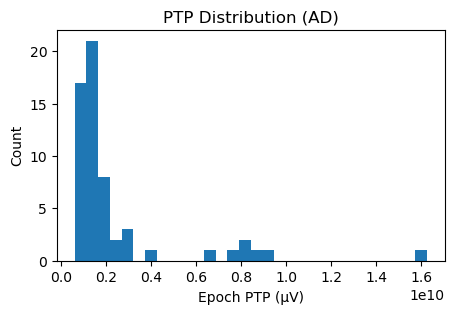

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# epochs: ICA 후, drop_bad 전의 EpochsArray
ptp_uv = epochs.get_data().ptp(axis=2).max(axis=1) * 1e6  # µV 단위로
plt.figure(figsize=(5,3))
plt.hist(ptp_uv, bins=30)
plt.xlabel('Epoch PTP (µV)')
plt.ylabel('Count')
plt.title('PTP Distribution (AD)')
plt.show()


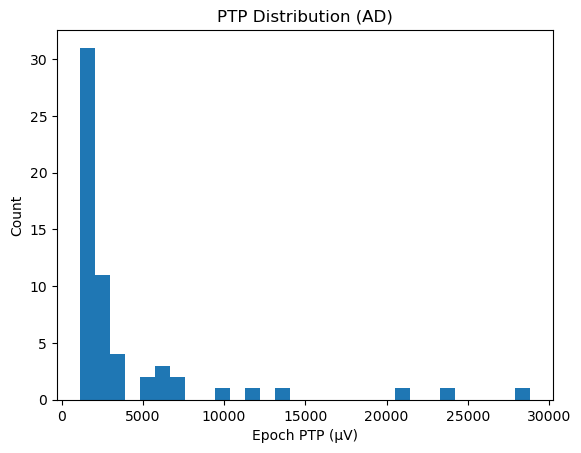

In [53]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import mne

# 1) .mat 파일 로드
mat = sio.loadmat(
    "C:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/AD.mat",
    struct_as_record=False,
    squeeze_me=True
)
# AD라는 key 로 저장된 ndarray를 꺼낸 뒤...
data = mat['AD']
# ndarray 안의 첫 번째 요소를 구조체로 추출
rec = data[0]   # 혹은 data.flatten()[0]

# 2) µV→V 변환 후 EpochsArray 준비
arr_uv = rec.epoch                      # (n_ch, n_times, n_epochs), in µV
arr_v  = arr_uv * 1e-6                  # convert µV → V
X      = arr_v.transpose(2, 0, 1)       # → (n_epochs, n_ch, n_times)

sfreq  = 200.0                          # 샘플링 주파수 직접 지정
info   = mne.create_info(['Fp1','Fz','Cz','Pz'], sfreq, 'eeg')
epochs = mne.EpochsArray(X, info, tmin=-1.0, verbose=False)

# 3) ICA 후 PTP 계산 (V 단위)
# epochs = ... (필터→노치→ICA 과정을 거친 epochs)
ptp_V = epochs.get_data().ptp(axis=2).max(axis=1)

# 4) 다시 µV로 변환해서 분포 시각화
ptp_uV = ptp_V * 1e6
plt.hist(ptp_uV, bins=30)
plt.xlabel('Epoch PTP (µV)')
plt.ylabel('Count')
plt.title('PTP Distribution (AD)')
plt.show()


## 1) 99번째 퍼센타일 기준으로 threshold 잡기

In [54]:
import numpy as np

# epochs: ICA 까지 완료된 EpochsArray (V 단위)
ptp_V  = epochs.get_data().ptp(axis=2).max(axis=1)  # 각 epoch의 peak-to-peak (Volts)
ptp_uV = ptp_V * 1e6                               # µV 단위로 변환

# 99번째 퍼센타일 계산
threshold_uV = np.percentile(ptp_uV, 99)
threshold_V  = threshold_uV * 1e-6
print(f"99th percentile PTP: {threshold_uV:.0f} µV")

# 이 임계치로 bad-epoch 제거
epochs_clean = epochs.copy().drop_bad(
    reject=dict(eeg=threshold_V), verbose=True
)
print(f" → {len(epochs_clean)}/{len(epochs)} epochs remain")


99th percentile PTP: 26055 µV
    Rejecting  epoch based on EEG : ['Cz']
1 bad epochs dropped
 → 58/59 epochs remain


## 2) 고정 5 000 µV 기준으로 threshold 잡기

In [55]:
threshold_uV = 5000       # µV
threshold_V  = threshold_uV * 1e-6
print(f"Manual threshold: {threshold_uV} µV")

epochs_clean = epochs.copy().drop_bad(
    reject=dict(eeg=threshold_V), verbose=True
)
print(f" → {len(epochs_clean)}/{len(epochs)} epochs remain")


Manual threshold: 5000 µV
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
13 bad epochs dropped
 → 46/59 epochs remain


## 3) 남은 에포크로 ERP/PSD 시각화

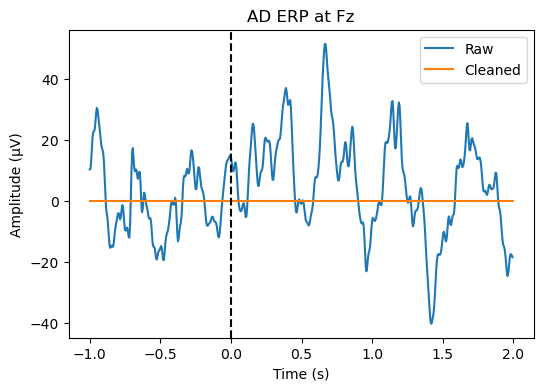

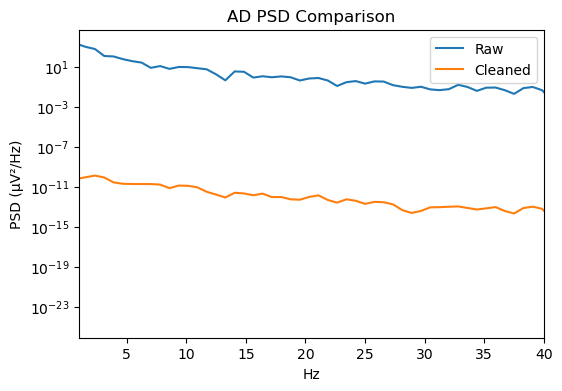

In [56]:
# ❶ Baseline correction
epochs_clean.apply_baseline((None, 0))

# ❷ ERP 비교 (Fz)
ev_raw   = raw_epochs_bc.copy().pick_channels(['Fz']).average()
ev_clean = epochs_clean.copy().pick_channels(['Fz']).average()

plt.figure(figsize=(6,4))
plt.plot(ev_raw.times,   ev_raw.data[0],   label='Raw')
plt.plot(ev_clean.times, ev_clean.data[0], label='Cleaned')
plt.axvline(0, color='k', ls='--')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (µV)')
plt.legend(); plt.title('AD ERP at Fz')
plt.show()

# ❸ PSD 비교
from scipy.signal import welch
nperseg = min(256, n_times)
psd_raw, psd_clean = [], []
for ch in range(n_ch):
    f, P_r = welch(raw_epochs_bc.get_data()[:,ch,:].mean(axis=0), 
                   fs=sfreq, nperseg=nperseg)
    _, P_c = welch(epochs_clean.get_data()[:,ch,:].mean(axis=0), 
                   fs=sfreq, nperseg=nperseg)
    psd_raw.append(P_r); psd_clean.append(P_c)

plt.figure(figsize=(6,4))
plt.semilogy(f, np.mean(psd_raw, axis=0), label='Raw')
plt.semilogy(f, np.mean(psd_clean, axis=0), label='Cleaned')
plt.xlim(1,40); plt.xlabel('Hz'); plt.ylabel('PSD (µV²/Hz)')
plt.legend(); plt.title('AD PSD Comparison')
plt.show()


### 이 히스토그램은 아티팩트 제거(artifact rejection) 단계 중, “bad-epoch” 기준을 정할 때 보는 QC(quality-control) 시각화입니다.

구체적으로 전처리 파이프라인에서는 아래 위치에 해당해요:

필터 → 노치 → ICA 까지 끝낸 뒤,

PTP(peak-to-peak) 분포 계산

히스토그램으로 PTP 분포를 시각화 ← 바로 이 부분

분포를 보고 임계치(threshold)(예: 99th 퍼센타일 또는 5 000 µV)를 선택

epochs.drop_bad(reject=dict(eeg=threshold)) 로 실제 bad-epoch 제거

즉, 3번 단계에서 “이렇게 생긴 분포를 보고 → 4번에서 기준을 잡았다”는 과정을 자료에 담는 거죠.
발표 자료에는

“ICA 이후 PTP 분포가 이렇다”

“상위 1%만 제거하기 위해 99th-percentile ≈3 000 µV 임계치를 선택했다”